In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.datasets as dset
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils

%config InlineBackend.figure_format = 'retina'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

manualSeed = 123
# Set the seed for NumPy
np.random.seed(manualSeed)

# Set the seed for PyTorch CPU
torch.manual_seed(manualSeed)

# Set the seed for PyTorch GPU (if available)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)

# Additional configurations for reproducibility (if desired)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )

        # Latent space
        self.fc_mu = nn.Linear(64*4*4, latent_dim)
        self.fc_logvar = nn.Linear(64*4*4, latent_dim)

        # Fully connected layer for decoding
        self.fc_decoder = nn.Linear(latent_dim, 64*4*4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        z = self.fc_decoder(z)
        z = z.view(z.size(0), 64, 4, 4)
        x = self.decoder(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Root directory for dataset
dataroot = "../data_meta_T/data_5000_h/"

# Hyperparameters
batch_size = 256
dataset = dset.ImageFolder(root=os.path.normpath(dataroot),
                           transform=transforms.Compose([
                               transforms.Grayscale(1),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize((0), (1)),                 
                           ]))


train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)


In [27]:
# Initialize the VAE model
def train_model(latent_dim, testdata,num_epochs):
    lr = 0.001
    
    kld_weight=1

    loss_list = []
    bce_list = []
    kld_list = []
    model = VAE(latent_dim).to(device)

    # Define the loss function

    def loss1(recon_x, x, mu, logvar,kld_weight):
        BCE = nn.BCELoss(reduction='sum')(recon_x, x)/batch_size
        return BCE
    def loss2(recon_x, x, mu, logvar,kld_weight):
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return KLD
    # def loss_function(recon_x, x, mu, logvar,kld_weight):
    #     BCE = loss1(recon_x, x, mu, logvar,kld_weight)
    #     KLD = loss2(recon_x, x, mu, logvar,kld_weight)
        
    #     return BCE + kld_weight*10*KLD

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)

            # Forward pass
            recon_data, mu, logvar = model(data)

            # Compute the loss

            # kl_divergence = 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp())
            # loss = F.binary_cross_entropy(recon_data, data, size_average=False) + kl_divergence
            BCE = loss1(recon_data, data, mu, logvar, kld_weight)
            kl = loss2(recon_data, data, mu, logvar, kld_weight)
            loss = BCE + kl
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Print progress
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Print epoch loss
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")
        loss_list.append(loss.item())
        bce_list.append(BCE.item())
        kld_list.append(kl.item())
    # Save the trained model
    model_name = "vae_bn_"+str(latent_dim)+"_model.pt"
    torch.save(model.state_dict(), model_name)

    plt.plot(loss_list,label='loss')
    plt.plot(bce_list,label='bce_loss')
    plt.plot(kld_list,label='kld_loss')
    plt.legend()
    plt.show()


    ## plot results 

    model.eval()

    with torch.no_grad():
        recon_data, _, _ = model(testdata)

    fig = plt.figure(figsize=(6, 4))
    font = {'family': 'serif', 'size': 12}
    plt.rc('font', **font)
    plt.axis("off")
    plt.title("VAE Generated (Dz = "+str(latent_dim)+")", fontsize=12)
    raw_data = recon_data[:16].clone()
    raw_data = raw_data*2-1
    temp = np.transpose(vutils.make_grid(raw_data.to(device), nrow=4,padding=5,normalize=False).cpu(),(1,2,0))

    temp[temp == 0] = np.nan

    plt.imshow(torch.mean(temp,2),cmap='jet',vmax=1.1,vmin=-1.1)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

In [28]:
dim_list = [8,16,32,64]
dim_list.reverse()
dim_list

[64, 32, 16, 8]

In [29]:
# data, _ = next(iter(train_loader))
# data = data.to(device)
# data = data.clone()
# dim_list = [8,16,32,64]
# dim_list.reverse()
# for latent_dim in dim_list:
#     train_model(latent_dim,data,400)
#     print('finish',latent_dim)

recon_error 0.098
recon_error 0.058
recon_error 0.03
recon_error 0.017
recon_error 0.013


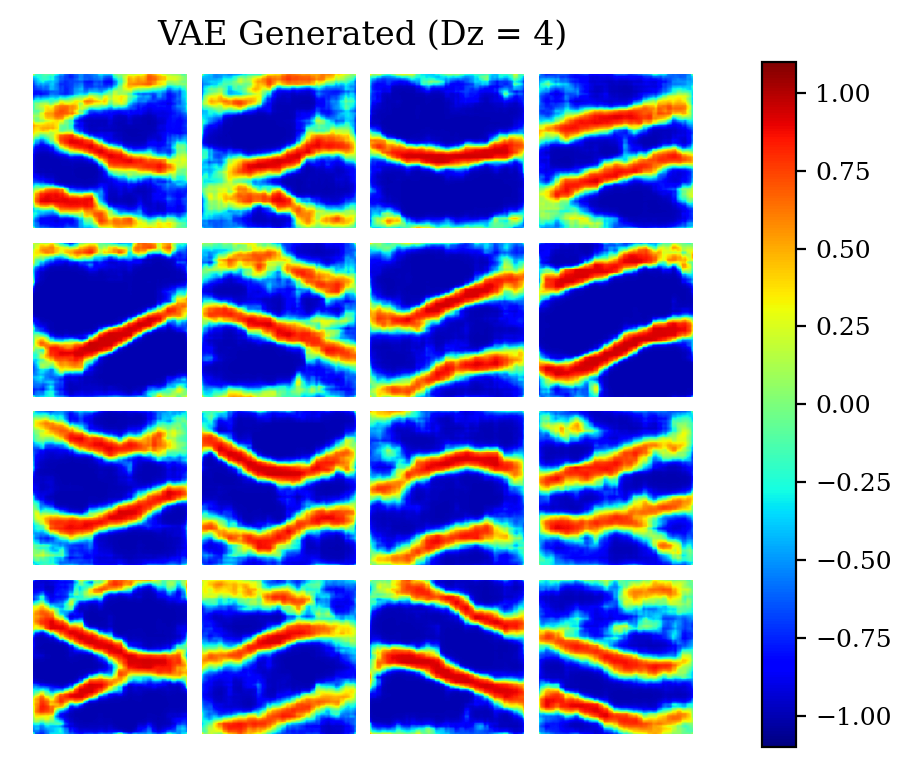

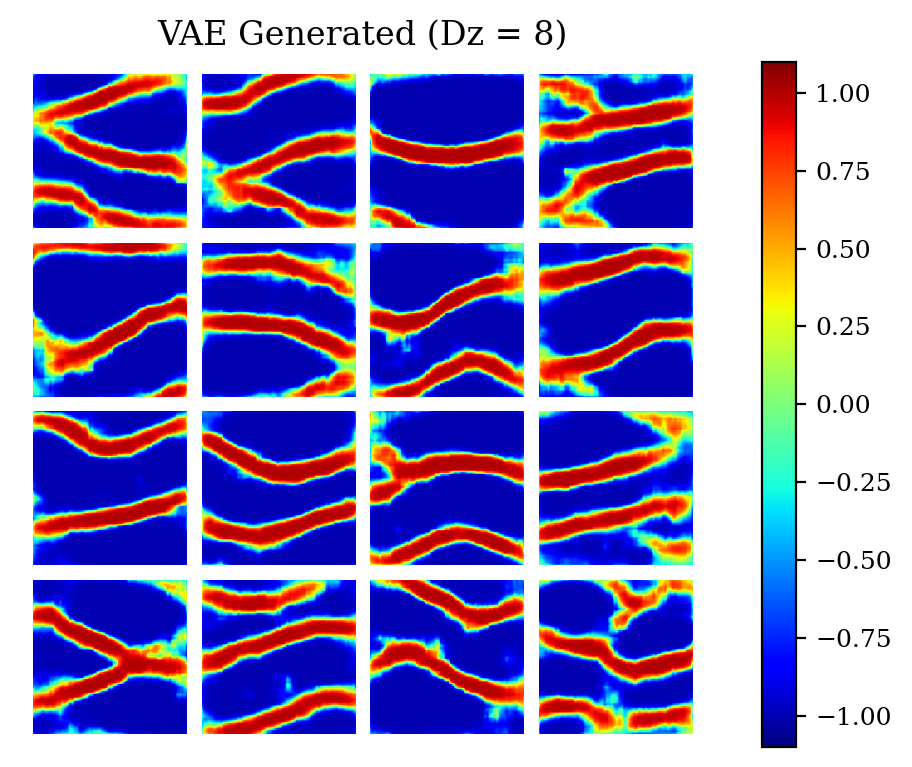

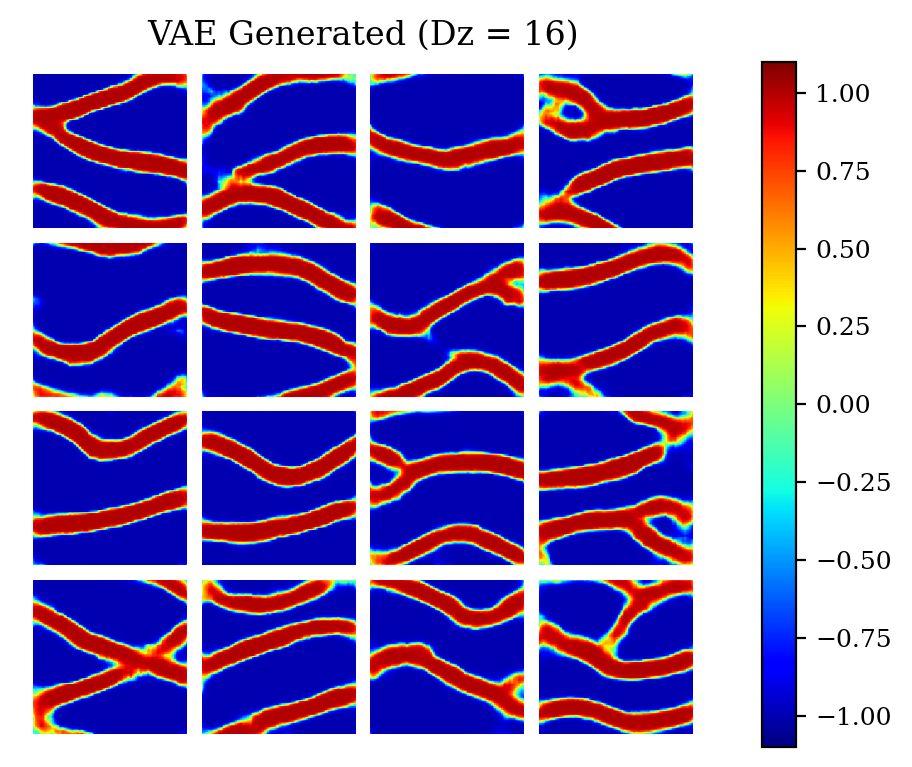

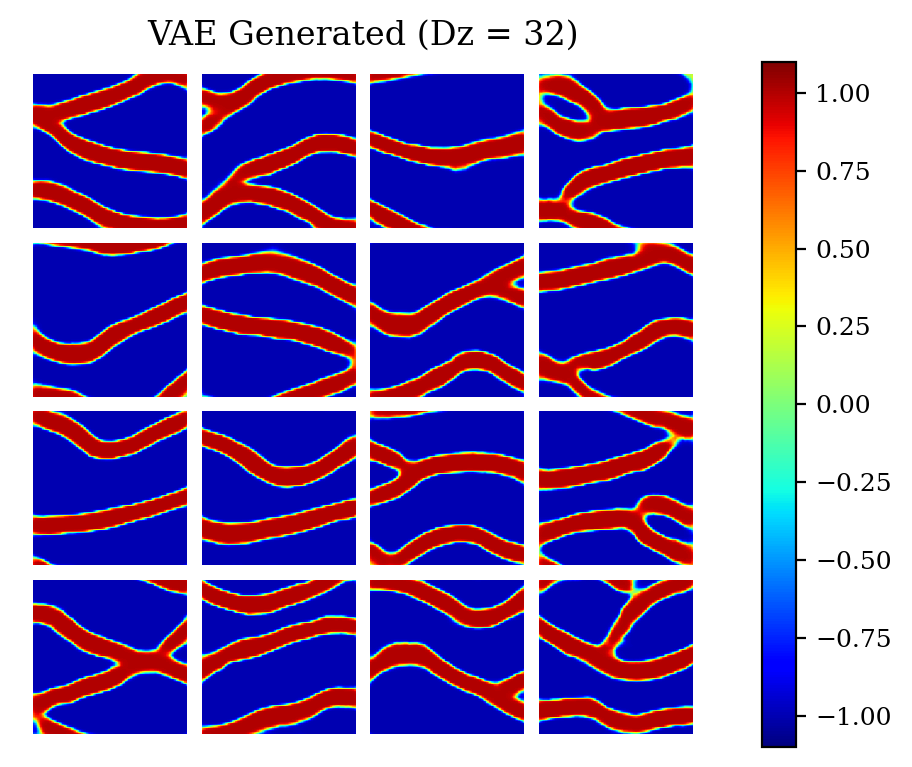

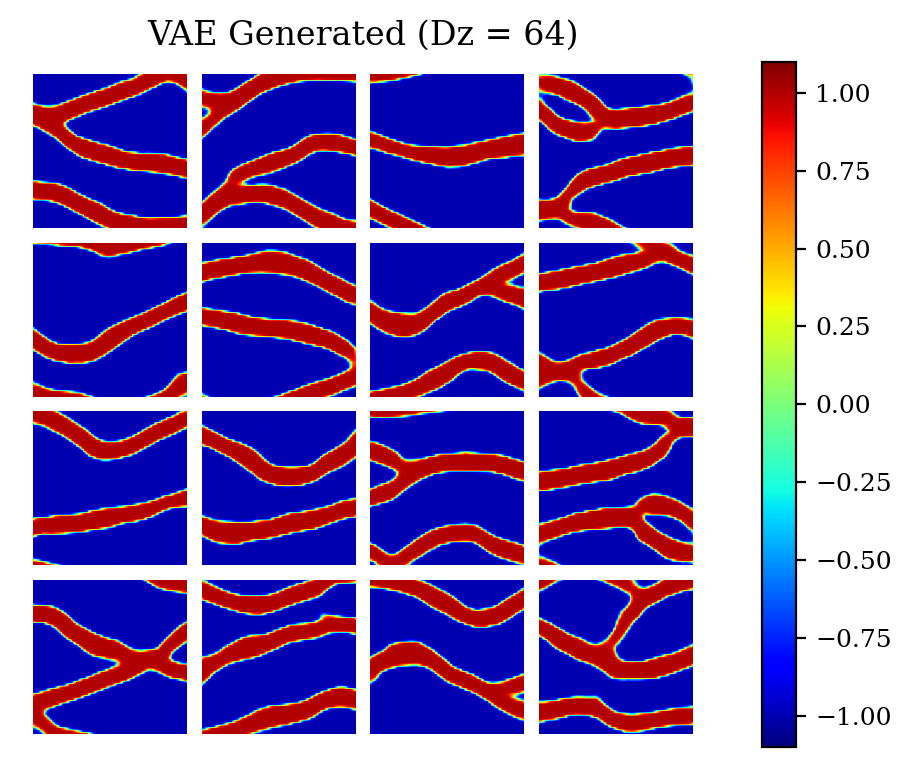

In [30]:
data, _ = next(iter(train_loader))
data = data.to(device)
data = data.clone()

recon_data_error = []
for latent_dim in [4,8,16,32,64]:
# Load the trained model
    model = VAE(latent_dim).to(device)

    model_name = "./Trained_model_BN/vae_bn_"+str(latent_dim)+"_model.pt"
    model.load_state_dict(torch.load(model_name))
    model.eval()

    with torch.no_grad():
        recon_data, _, _ = model(data)

    fig = plt.figure(figsize=(6, 4))
    font = {'family': 'serif', 'size': 12}
    plt.rc('font', **font)
    plt.axis("off")
    plt.title("VAE Generated (Dz = "+str(latent_dim)+")", fontsize=12)
    raw_data = recon_data[:16].clone()

    ## calculate reconstruction error
    recon_error = torch.mean((raw_data - data[:16])**2)
    recon_data_error.append(recon_error.item())
    print('recon_error',np.round(recon_error.item(),3))
    ##
    raw_data = raw_data*2-1
    temp = np.transpose(vutils.make_grid(raw_data.to(device), nrow=4,padding=5,normalize=False).cpu(),(1,2,0))

    temp[temp == 0] = np.nan

    plt.imshow(torch.mean(temp,2),cmap='jet',vmax=1.1,vmin=-1.1)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=9)
    plt.tight_layout()

In [31]:
latent_dim = 16
model = VAE(latent_dim).to(device)

model_name = "./Trained_model_BN/vae_bn_"+str(latent_dim)+"_model.pt"
model.load_state_dict(torch.load(model_name))
model.eval()

with torch.no_grad():
    recon_data, mu, sigma = model(data[[11]])



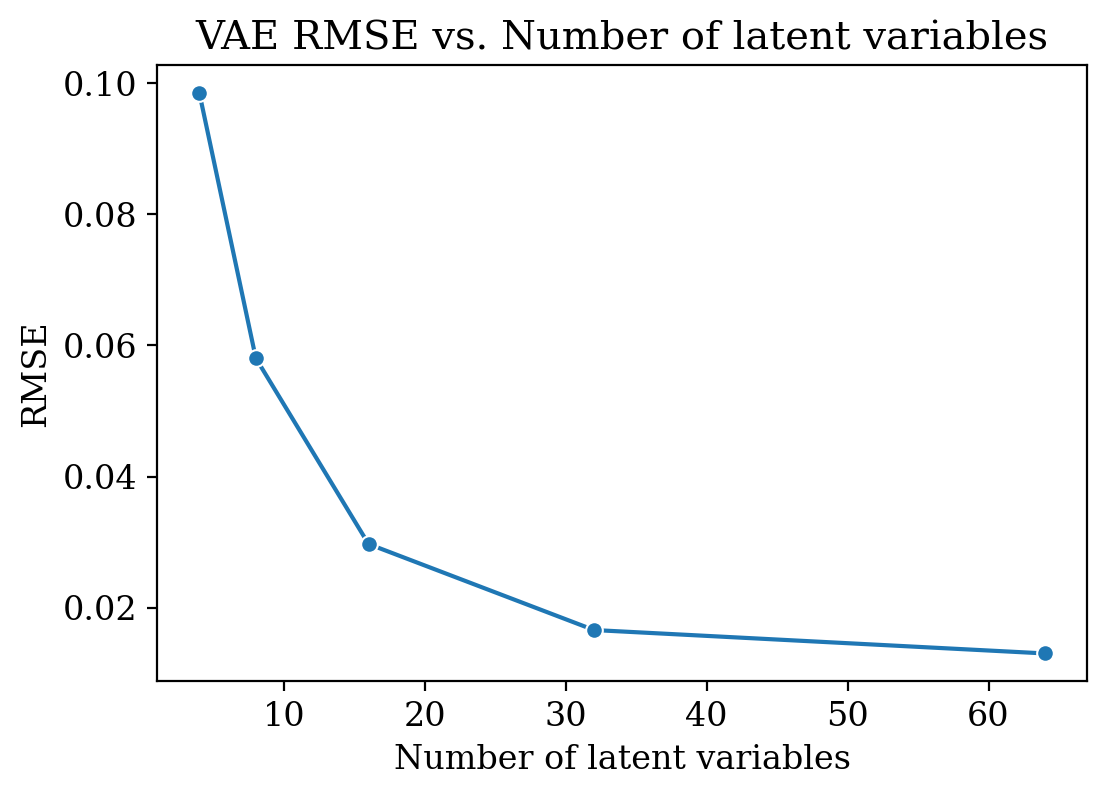

Text(0.5, 0, 'Number of latent variables')

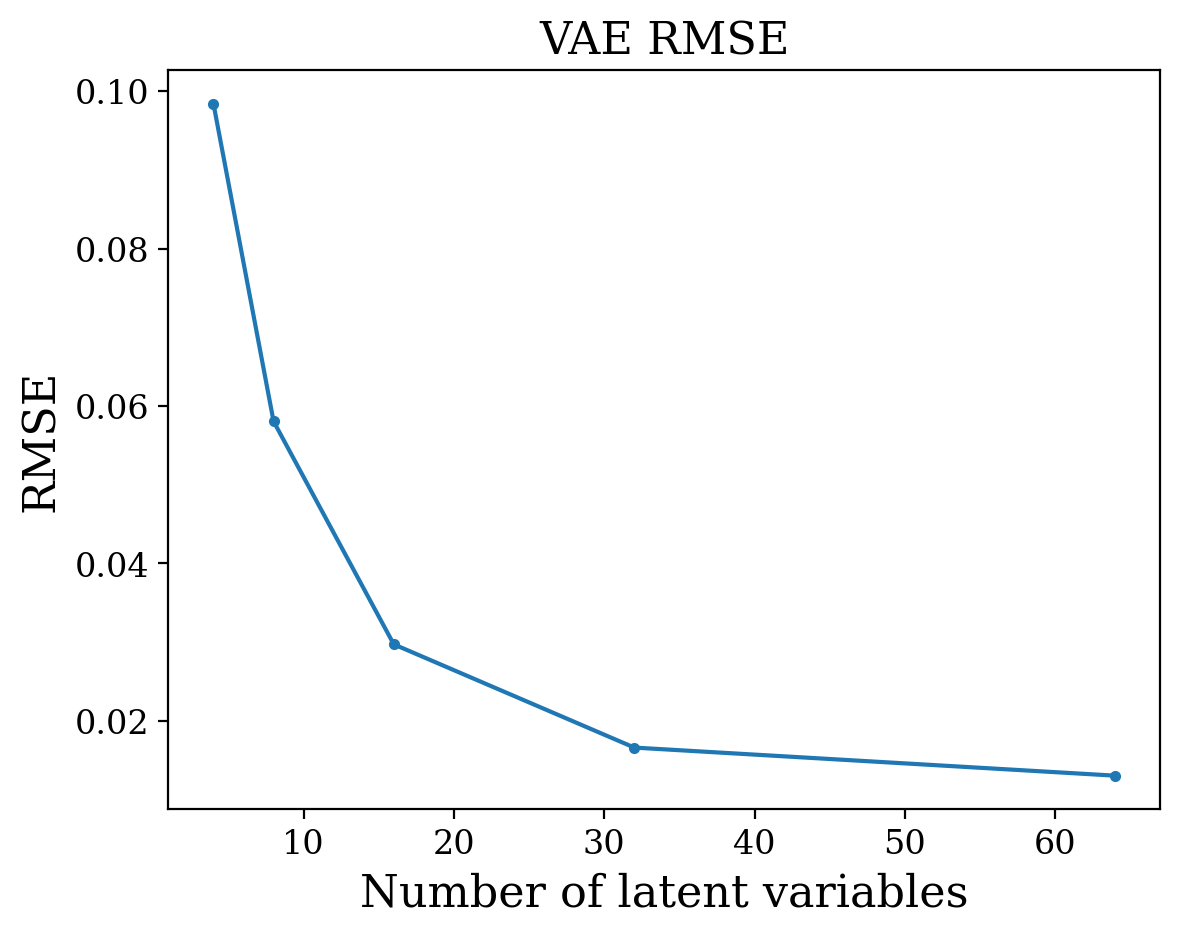

In [32]:
# Create a line plot using sns.lineplot
import seaborn as sns

plt.figure(figsize=(6, 4))  # Optional: Set the figure size
sns.lineplot(x=[4,8,16,32,64], y=recon_data_error, marker="o")

# Add labels and title
plt.xlabel("Number of latent variables")
plt.ylabel("RMSE")
plt.title("VAE RMSE vs. Number of latent variables")

# Show the plot
plt.show()

plt.plot([4,8,16,32,64],recon_data_error,'.-')
plt.title('VAE RMSE',fontsize=16)
plt.ylabel('RMSE',fontsize=16)
plt.xlabel('Number of latent variables',fontsize=16)

In [33]:
# fig = plt.figure(figsize=(6, 4))
# font = {'family': 'serif', 'size': 12}
# plt.rc('font', **font)
# plt.axis("off")
# plt.title("Real image", fontsize=12)
# raw_data =data[:16].clone()
# raw_data[raw_data == 0] = -1
# temp = np.transpose(vutils.make_grid(raw_data.to(device), nrow=4,padding=5,normalize=False).cpu(),(1,2,0))

# temp[temp == 0] = np.nan

# plt.imshow(torch.mean(temp,2),cmap='jet',vmax=1.1,vmin=-1.1)
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=9)
# plt.tight_layout()

In [34]:
# data, _ = next(iter(train_loader))
# data = data.to(device)
# data = data.clone()
# for latent_dim in [8,16,32,64]:
#     model = VAE(latent_dim).to(device)
#     model_name = "./Trained_model_BN/vae_bn_"+str(latent_dim)+"_model.pt"
#     model.load_state_dict(torch.load(model_name))
#     model.eval()

#     with torch.no_grad():
#         recon_data, mu,sig= model(data)

#     z_output = model.reparameterize(mu,sig)
#     z_output
#     np.save('z'+str(latent_dim)+'_output.npy',z_output.cpu().numpy())

# random generate images

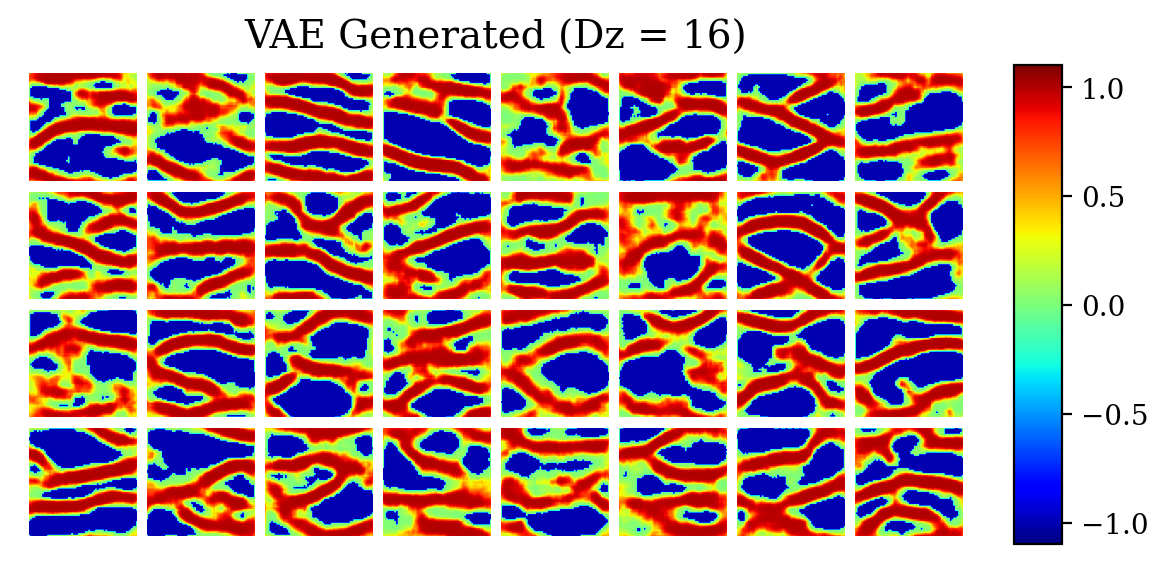

In [35]:
%config InlineBackend.figure_format = 'retina'
manualSeed = 123
# Set the seed for NumPy
np.random.seed(manualSeed)

# Set the seed for PyTorch CPU
torch.manual_seed(manualSeed)

# Set the seed for PyTorch GPU (if available)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)
latent_dim = 16
model = VAE(latent_dim).to(device)

model_name = "./Trained_model_BN/vae_bn_"+str(latent_dim)+"_model.pt"
model.load_state_dict(torch.load(model_name))
model.eval()

with torch.no_grad():
    recon_data, mu_, sig_ = model(data)
bsize = 32
z_samples = np.array([np.random.normal(0, np.sqrt(0.5), size=bsize) for i in range(latent_dim)]).T
recon_data = model.decode(torch.from_numpy(z_samples).float().to(device))

fig = plt.figure(figsize=(6, 4))
font = {'family': 'serif', 'size': 12}
plt.rc('font', **font)
plt.axis("off")
plt.title("VAE Generated (Dz = "+str(latent_dim)+")", fontsize=14)
raw_data = recon_data[:bsize].clone()
raw_data[raw_data < 0.005] = -1
temp = np.transpose(vutils.make_grid(raw_data.to(device), nrow=8,padding=5,normalize=False).cpu(),(1,2,0))

temp[temp == 0] = np.nan
font = {'family': 'serif', 'size': 12}
cax = plt.imshow(torch.mean(temp,2),cmap='jet',vmax=1.1,vmin=-1.1)
cbar = plt.colorbar(cax, fraction=0.046, pad=0.04, aspect=10)
cbar.ax.tick_params(labelsize=10)
plt.tight_layout()

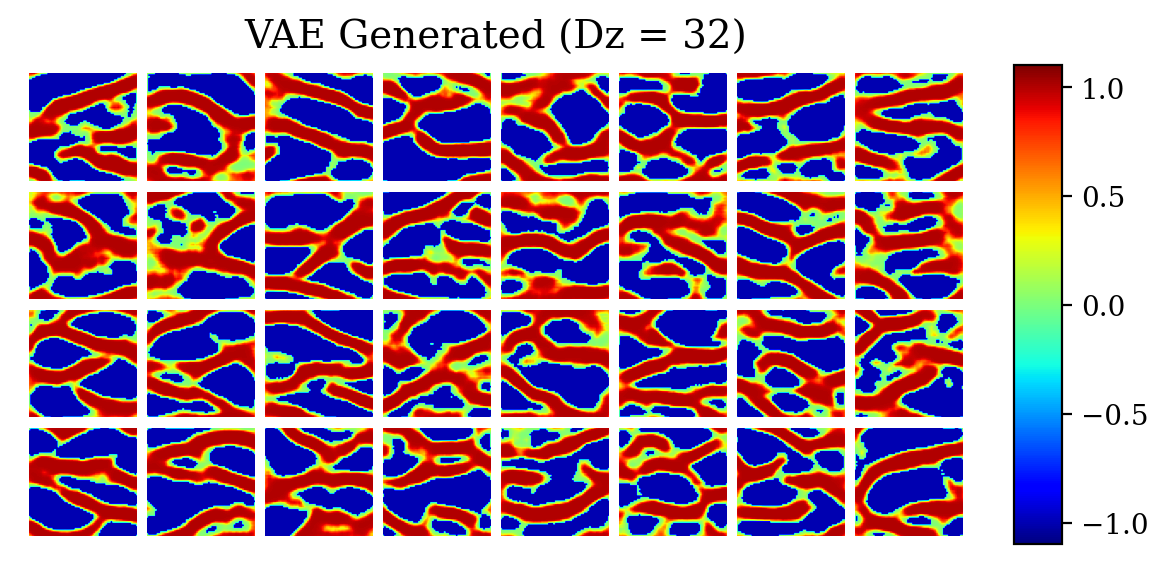

In [36]:

manualSeed = 123
# Set the seed for NumPy
np.random.seed(manualSeed)

# Set the seed for PyTorch CPU
torch.manual_seed(manualSeed)

# Set the seed for PyTorch GPU (if available)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)
latent_dim = 32
model = VAE(latent_dim).to(device)

model_name = "./Trained_model_BN/vae_bn_"+str(latent_dim)+"_model.pt"
model.load_state_dict(torch.load(model_name))
model.eval()

with torch.no_grad():
    recon_data, mu_, sig_ = model(data)
bsize = 32
z_samples = np.array([np.random.normal(0, np.sqrt(0.5), size=bsize) for i in range(latent_dim)]).T
recon_data = model.decode(torch.from_numpy(z_samples).float().to(device))

fig = plt.figure(figsize=(6, 4))
font = {'family': 'serif', 'size': 12}
plt.rc('font', **font)
plt.axis("off")
plt.title("VAE Generated (Dz = "+str(latent_dim)+")", fontsize=14)
raw_data = recon_data[:bsize].clone()
raw_data[raw_data < 0.005] = -1
temp = np.transpose(vutils.make_grid(raw_data.to(device), nrow=8,padding=5,normalize=False).cpu(),(1,2,0))

temp[temp == 0] = np.nan
font = {'family': 'serif', 'size': 12}
cax = plt.imshow(torch.mean(temp,2),cmap='jet',vmax=1.1,vmin=-1.1)
cbar = plt.colorbar(cax, fraction=0.046, pad=0.04, aspect=10)
cbar.ax.tick_params(labelsize=10)
plt.tight_layout()

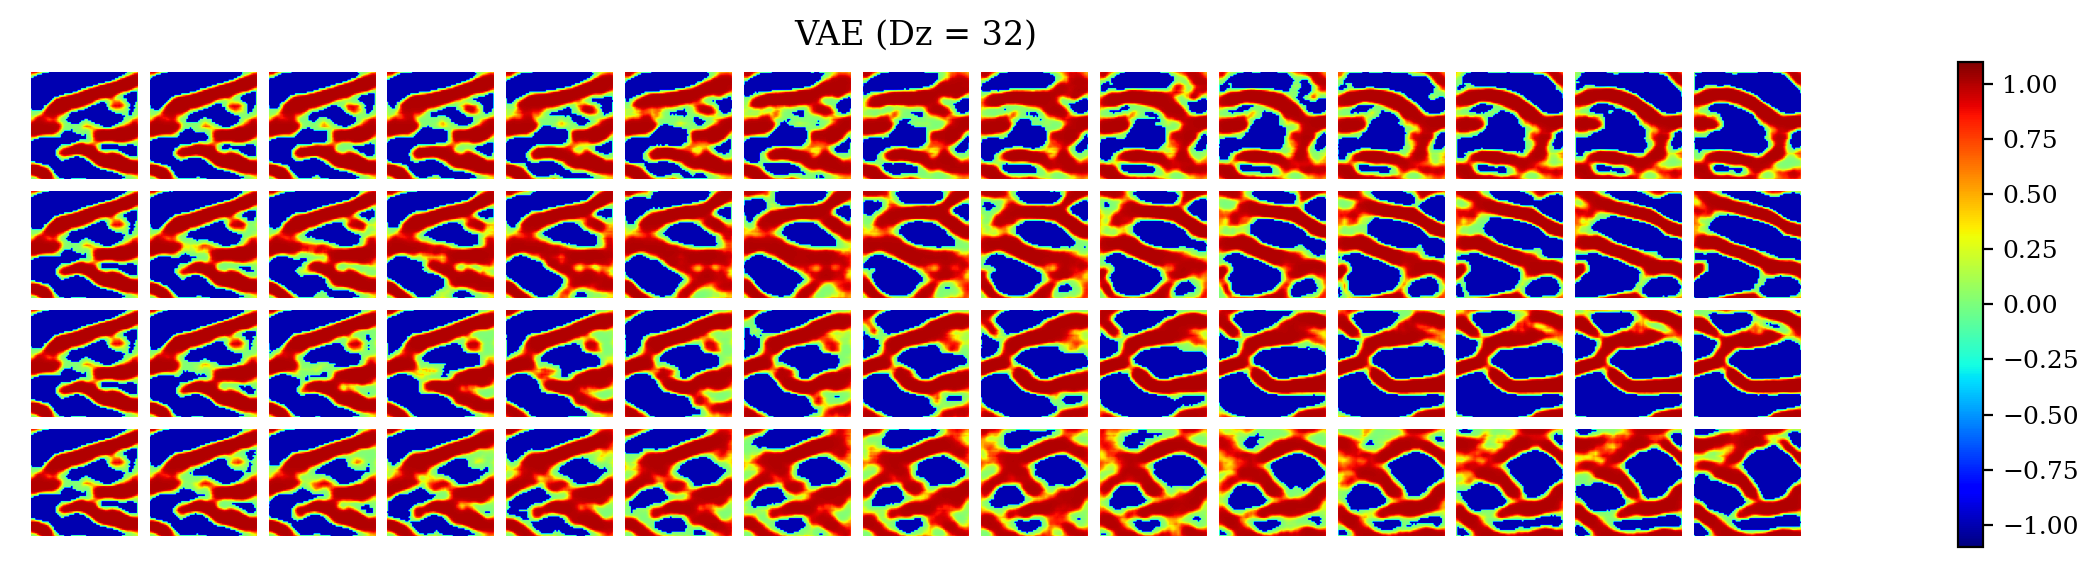

In [37]:
z = torch.from_numpy(z_samples).float().to(device)
lvec2 = z[[0]]
lvec1 = torch.zeros_like(z[[4]])-lvec2

lvec_list = z[1:5]
STEPS = 15
diff = lvec2 - lvec1
step = diff / STEPS

current = lvec1.clone()
input = []
# current = lvec1
result =[]
for i in lvec_list:
    diff = lvec2 - i
    step = diff / (STEPS-1)
    current = lvec2.clone()
    for j in (range(STEPS)):
    # z = torch.from_numpy(current).to(device)
        # print(i.shape)
        with torch.no_grad():
            synth_image = model.decode(current)
            synth_image[synth_image < 0.005] = -1
        result.append(synth_image[0])
        input.append(current)
        current = current - step
out = vutils.make_grid(result, nrow = STEPS,padding=6)
out[out == 0] = np.nan
fig = plt.figure(figsize=(15, 3))
plt.axis("off")
plt.title("VAE (Dz = "+str(latent_dim)+")",fontsize=12)
plt.imshow(np.mean(np.transpose(out.cpu().detach().numpy(),(1,2,0)),axis =2),cmap = 'jet', vmin=-1.1, vmax=1.1)
plt.tight_layout()
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=9)

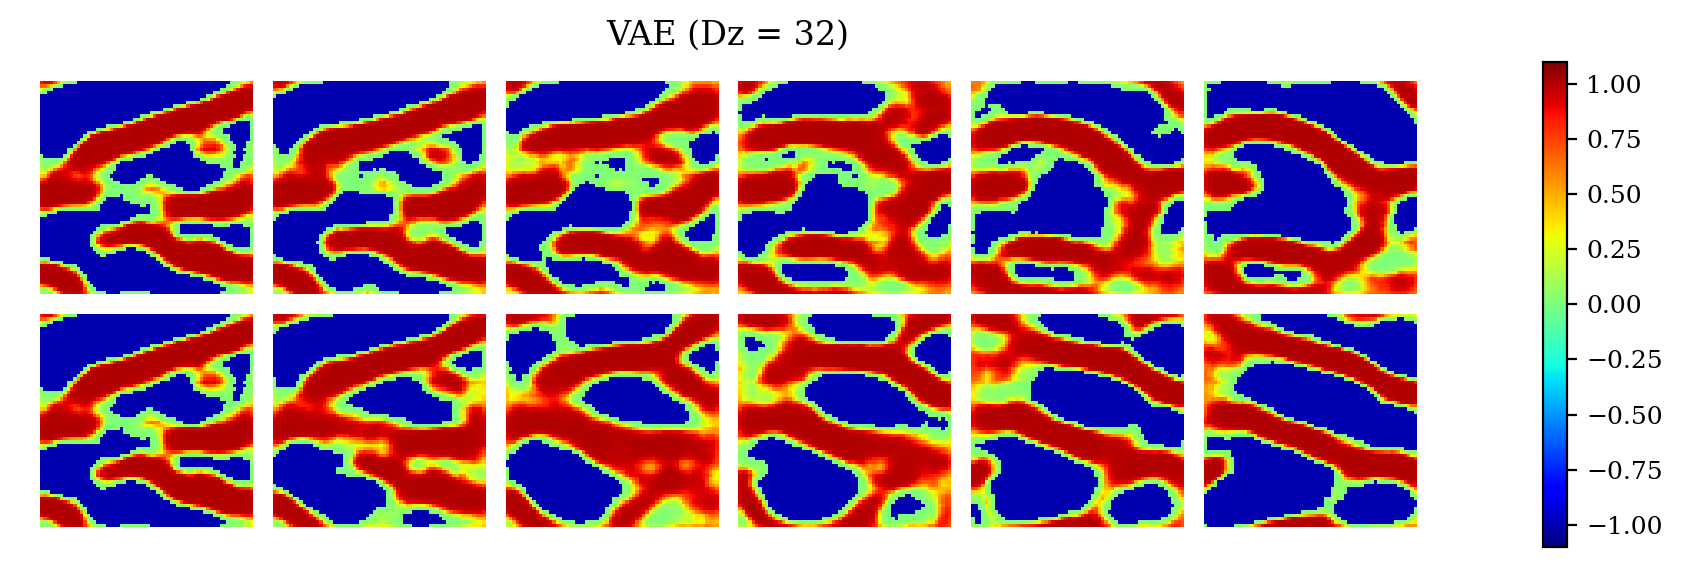

In [44]:
z = torch.from_numpy(z_samples).float().to(device)
lvec2 = z[[0]]
lvec1 = torch.zeros_like(z[[4]])-lvec2

lvec_list = z[1:3]
STEPS = 6
diff = lvec2 - lvec1
step = diff / STEPS

current = lvec1.clone()
input = []
# current = lvec1
result =[]
for i in lvec_list:
    diff = lvec2 - i
    step = diff / (STEPS-1)
    current = lvec2.clone()
    for j in (range(STEPS)):
    # z = torch.from_numpy(current).to(device)
        # print(i.shape)
        with torch.no_grad():
            synth_image = model.decode(current)
            synth_image[synth_image < 0.005] = -1
        result.append(synth_image[0])
        input.append(current)
        current = current - step
out = vutils.make_grid(result, nrow = STEPS,padding=6)
out[out == 0] = np.nan
fig = plt.figure(figsize=(11, 3))
plt.axis("off")
plt.title("VAE (Dz = "+str(latent_dim)+")",fontsize=12)
plt.imshow(np.mean(np.transpose(out.cpu().detach().numpy(),(1,2,0)),axis =2),cmap = 'jet', vmin=-1.1, vmax=1.1)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=9)
plt.tight_layout()

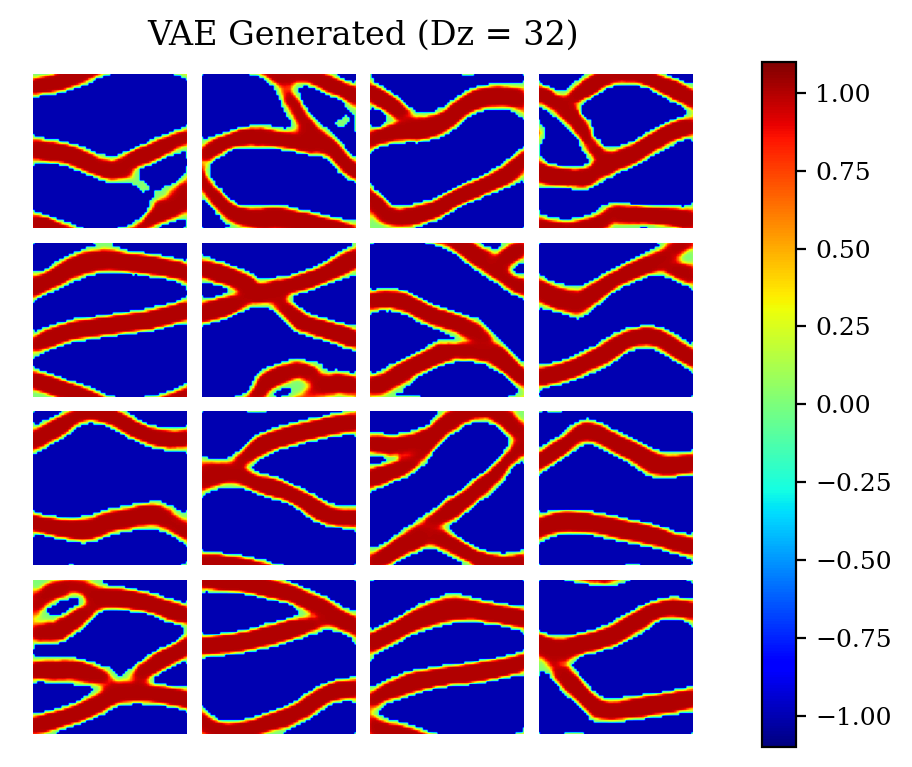

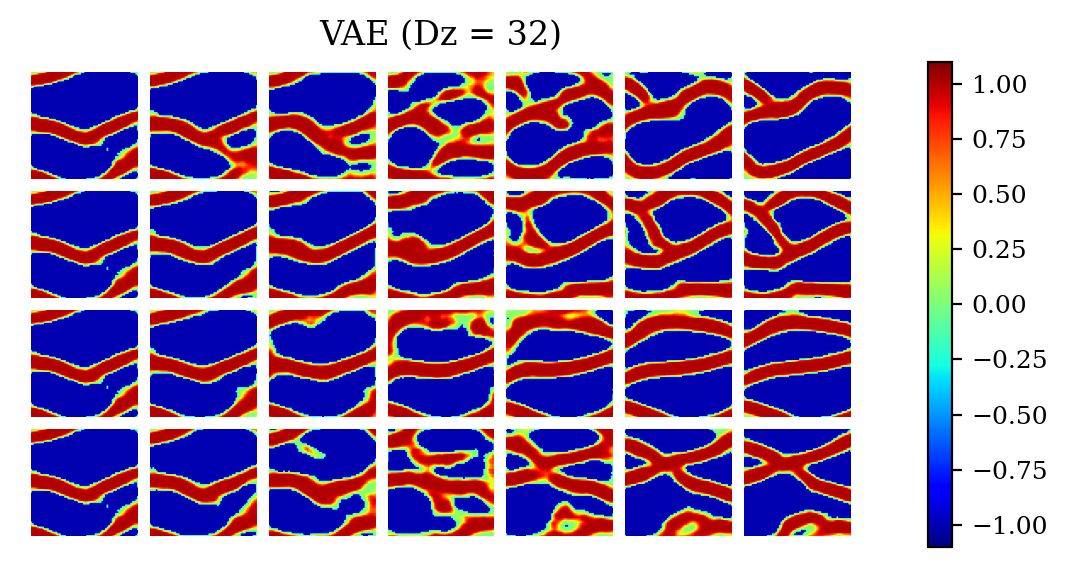

In [16]:
latent_dim = 32
model = VAE(latent_dim).to(device)

model_name = "./Trained_model_BN/vae_bn_"+str(latent_dim)+"_model.pt"
model.load_state_dict(torch.load(model_name))
model.eval()

with torch.no_grad():
    recon_data, mu_, sig_ = model(data)

z = model.reparameterize(mu_, sig_)


fig = plt.figure(figsize=(6, 4))
font = {'family': 'serif', 'size': 12}
plt.rc('font', **font)
plt.axis("off")
plt.title("VAE Generated (Dz = "+str(latent_dim)+")", fontsize=12)
raw_data = recon_data[:16].clone()
raw_data[raw_data < 0.005] = -1
temp = np.transpose(vutils.make_grid(raw_data.to(device), nrow=4,padding=5,normalize=False).cpu(),(1,2,0))

temp[temp == 0] = np.nan

plt.imshow(torch.mean(temp,2),cmap='jet',vmax=1.1,vmin=-1.1)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=9)
plt.tight_layout()
lvec2 = z[[0]]
lvec1 = torch.zeros_like(z[[4]])-lvec2

lvec_list = z[2:6]
STEPS = 7
diff = lvec2 - lvec1
step = diff / STEPS

current = lvec1.clone()
input = []
# current = lvec1
result =[]
for i in lvec_list:
    diff = lvec2 - i
    step = diff / (STEPS-1)
    current = lvec2.clone()
    for j in (range(STEPS)):
    # z = torch.from_numpy(current).to(device)
        # print(i.shape)
        with torch.no_grad():
            synth_image = model.decode(current)
            synth_image[synth_image < 0.005] = -1
        result.append(synth_image[0])
        input.append(current)
        current = current - step
out = vutils.make_grid(result, nrow = STEPS,padding=6)
out[out == 0] = np.nan
fig = plt.figure(figsize=(7, 3))
plt.axis("off")
plt.title("VAE (Dz = "+str(latent_dim)+")",fontsize=12)
plt.imshow(np.mean(np.transpose(out.cpu().detach().numpy(),(1,2,0)),axis =2),cmap = 'jet', vmin=-1.1, vmax=1.1)
plt.tight_layout()
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=9)

plt.show()